In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

Use 500-core output. The 1000-core one seems broken.

In [2]:
ls -lh /n/scratchlfs/ac290r/case1/ParallelDatabase/case1.exo

-rw-rw----+ 1 zhuangjw ac290r 22G Mar 10 15:20 /n/scratchlfs/ac290r/case1/ParallelDatabase/case1.exo


In [3]:
ds = xr.open_dataset('/n/scratchlfs/ac290r/case1/ParallelDatabase/case1.exo', chunks={'time_step': 15})

# Pre-processing

The original data do not have 2D grid structure. First convert them to 2D grid.

In [4]:
ds['name_nod_var'].values  # the second `vals_nod_var` variable is temperature

array([b'PRESSURE', b'TEMPERATURE', b'UX', b'UY'], dtype='|S33')

In [5]:
dr_1d = ds['vals_nod_var2']  # this is temperature

In [6]:
dr_1d

<xarray.DataArray 'vals_nod_var2' (time_step: 225, num_nodes: 2100225)>
dask.array<shape=(225, 2100225), dtype=float64, chunksize=(15, 2100225)>
Dimensions without coordinates: time_step, num_nodes

In [7]:
nx = 2049
ny = 1025
nx * ny  # equals to 'num_nodes'

2100225

In [8]:
t_val = ds['time_whole'].load()
t_val

<xarray.DataArray 'time_whole' (time_step: 225)>
array([0.000000e+00, 1.000000e-04, 4.115042e-04, ..., 2.203750e-01,
       2.213750e-01, 2.223750e-01])
Dimensions without coordinates: time_step

In [9]:
x_1d = ds['coordx'][0:nx].load()
x_1d

<xarray.DataArray 'coordx' (num_nodes: 2049)>
array([0.000000e+00, 9.765625e-04, 1.953125e-03, ..., 1.998047e+00,
       1.999023e+00, 2.000000e+00])
Dimensions without coordinates: num_nodes

In [10]:
y_1d = ds['coordy'][::nx].load()
y_1d

<xarray.DataArray 'coordy' (num_nodes: 1025)>
array([0.000000e+00, 2.353095e-06, 9.412359e-06, ..., 9.999906e-01,
       9.999976e-01, 1.000000e+00])
Dimensions without coordinates: num_nodes

In [11]:
# reshape to [time, y, x]
data_2d = dr_1d.data.reshape(-1, ny, nx)

In [12]:
data_2d

dask.array<reshape, shape=(225, 1025, 2049), dtype=float64, chunksize=(15, 1025, 2049)>

In [13]:
dr = xr.DataArray(data_2d, name='temperature', dims=['time', 'y', 'x'],
                  coords={'time': t_val.values, 'y': y_1d.values, 'x': x_1d.values})

In [14]:
dr

<xarray.DataArray 'temperature' (time: 225, y: 1025, x: 2049)>
dask.array<shape=(225, 1025, 2049), dtype=float64, chunksize=(15, 1025, 2049)>
Coordinates:
  * time     (time) float64 0.0 0.0001 0.0004115 0.001375 0.002375 0.003375 ...
  * y        (y) float64 0.0 2.353e-06 9.412e-06 2.118e-05 3.765e-05 ...
  * x        (x) float64 0.0 0.0009766 0.001953 0.00293 0.003906 0.004883 ...

In [16]:
# very big even for a single variable
dr.nbytes / 1e9  # GB

3.780405

In [17]:
# Only need to run once. Can simply open the processed file next time.
%time dr.to_netcdf('./temperature_512core_processed.nc')

CPU times: user 1.34 s, sys: 8.57 s, total: 9.91 s
Wall time: 1min 7s


In [5]:
# reopen file to make sure everything looks good
dr = xr.open_dataarray('./temperature_512core_processed.nc')
dr

<xarray.DataArray 'temperature' (time: 225, y: 1025, x: 2049)>
[472550625 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.0001 0.0004115 0.001375 0.002375 0.003375 ...
  * y        (y) float64 0.0 2.353e-06 9.412e-06 2.118e-05 3.765e-05 ...
  * x        (x) float64 0.0 0.0009766 0.001953 0.00293 0.003906 0.004883 ...

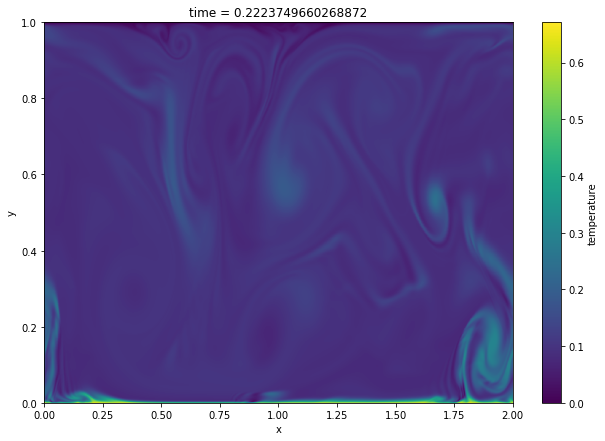

In [4]:
# a quick plotting test
dr[-1].plot(size=7)